# Import

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from lightgbm import LGBMRegressor
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

# Data Load

In [4]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('testA.csv')

# Feature Engineering

### 1. Time procession

In [5]:
train_data['datetime'] = pd.to_datetime(train_data['datetime'])
test_data['datetime'] = pd.to_datetime(test_data['datetime'])
train_data['datetime_hour'] = train_data['datetime'].dt.hour
test_data['datetime_hour'] = test_data['datetime'].dt.hour

train_data.drop('datetime', axis=1, inplace=True)
test_data.drop('datetime', axis=1, inplace=True)


### 2. dimension ordinal

In [6]:
for col in ['ad_id', 'ad_set_id', 'campaign_id', 'product_id', 'account_id', 'post_id_emb', 'post_type', 'countries']:
    lbl = LabelEncoder()
    lbl.fit(list(train_data[col]) + list(test_data[col]))
    train_data[col] = lbl.transform(list(train_data[col]))
    test_data[col] = lbl.transform(list(test_data[col]))


### 3. 二度特征生成：各品类ROI均值

In [7]:
train_data['product_id_roi_mean'] = train_data['product_id'].map(train_data.groupby(['product_id'])['roi'].mean())
test_data['product_id_roi_mean'] = test_data['product_id'].map(train_data.groupby(['product_id'])['roi'].mean())

train_data['account_id_roi_mean'] = train_data['account_id'].map(train_data.groupby(['account_id'])['roi'].mean())
test_data['account_id_roi_mean'] = test_data['account_id'].map(train_data.groupby(['account_id'])['roi'].mean())

train_data['countries_roi_mean'] = train_data['countries'].map(train_data.groupby(['countries'])['roi'].mean())
test_data['countries_roi_mean'] = test_data['countries'].map(train_data.groupby(['countries'])['roi'].mean())

train_data['datetime_hour_roi_mean'] = train_data['datetime_hour'].map(train_data.groupby(['datetime_hour'])['roi'].mean())
test_data['datetime_hour_roi_mean'] = test_data['datetime_hour'].map(train_data.groupby(['datetime_hour'])['roi'].mean())

In [8]:
train_data

,ad_id,ad_set_id,campaign_id,product_id,account_id,post_id_emb,post_type,countries,gender,age_min,...,cum_initiates_checkout,cum_purchase,cum_income_1,cum_income_2,roi,datetime_hour,product_id_roi_mean,account_id_roi_mean,countries_roi_mean,datetime_hour_roi_mean
0,1,0,0,209,1,2249,2,19,0,18,...,6,2,51.96,0.0,0.0,0,1.606082,2.249979,1.563869,1.805425
1,1,0,0,209,1,2249,2,19,0,18,...,6,2,51.96,0.0,0.0,1,1.606082,2.249979,1.563869,1.798679
2,1,0,0,209,1,2249,2,19,0,18,...,6,2,51.96,0.0,0.0,2,1.606082,2.249979,1.563869,1.802189
3,1,0,0,209,1,2249,2,19,0,18,...,6,2,51.96,0.0,0.0,3,1.606082,2.249979,1.563869,1.802148
4,1,0,0,209,1,2249,2,19,0,18,...,6,2,51.96,0.0,0.0,4,1.606082,2.249979,1.563869,1.801525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
656414,7364,3792,2416,135,31,1812,3,10,2,25,...,0,0,0.00,0.0,0.0,8,1.549928,1.502077,1.433427,1.829020
656415,7364,3792,2416,135,31,1812,3,10,2,25,...,0,0,0.00,0.0,0.0,9,1.549928,1.502077,1.433427,1.817643
656416,7364,3792,2416,135,31,1812,3,10,2,25,...,0,0,0.00,0.0,0.0,10,1.549928,1.502077,1.433427,1.809741
656417,7364,3792,2416,135,31,1812,3,10,2,25,...,0,0,0.00,0.0,0.0,11,1.549928,1.502077,1.433427,1.803130


### 4. 共线性特征剔除

In [15]:
train_data.describe()

,ad_id,ad_set_id,campaign_id,product_id,account_id,post_id_emb,post_type,countries,gender,age_min,...,cum_initiates_checkout,cum_purchase,cum_income_1,cum_income_2,roi,datetime_hour,product_id_roi_mean,account_id_roi_mean,countries_roi_mean,datetime_hour_roi_mean
count,656419.000000,656419.000000,656419.000000,656419.000000,656419.000000,656419.000000,656419.000000,656419.000000,656419.000000,656419.000000,...,656419.000000,656419.000000,656419.000000,656419.000000,656419.000000,656419.000000,656419.000000,656419.000000,656419.000000,656419.000000
mean,2850.487204,1310.900810,826.792236,194.874542,36.367354,1385.273194,2.052962,14.094560,0.339911,26.312738,...,63.349342,44.128231,3966.223461,998.550507,1.806511,5.953831,1.806511,1.806511,1.806511,1.806511
std,2238.173453,1137.995833,694.090276,152.223122,22.697171,805.120579,0.554666,2.519885,0.746566,8.859848,...,152.010350,108.684681,9156.645844,3617.734562,2.659601,3.757275,0.472268,0.408388,0.203219,0.007514
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,...,-10.000000,-4.000000,-511.960000,0.000000,-12.882738,0.000000,0.000000,0.000000,0.000000,1.798679
25%,905.000000,313.000000,235.000000,43.000000,13.000000,611.000000,2.000000,15.000000,0.000000,18.000000,...,2.000000,2.000000,135.940000,0.000000,0.000000,3.000000,1.600364,1.651574,1.859006,1.802189
50%,2385.000000,999.000000,664.000000,139.000000,36.000000,1488.000000,2.000000,15.000000,0.000000,25.000000,...,14.000000,9.000000,886.990000,0.000000,1.141458,6.000000,1.814092,1.905039,1.859006,1.804534
75%,4691.000000,2184.500000,1331.000000,343.000000,57.000000,2086.000000,2.000000,15.000000,0.000000,25.000000,...,54.000000,38.000000,3599.550000,251.860000,2.611712,9.000000,2.214228,2.061597,1.859006,1.806698
max,7364.000000,3799.000000,2423.000000,475.000000,76.000000,2668.000000,6.000000,20.000000,2.000000,55.000000,...,2364.000000,1599.000000,131966.090000,59035.880000,67.430117,12.000000,5.315806,2.776974,2.512746,1.829020


In [17]:
matrix = train_data.corr()

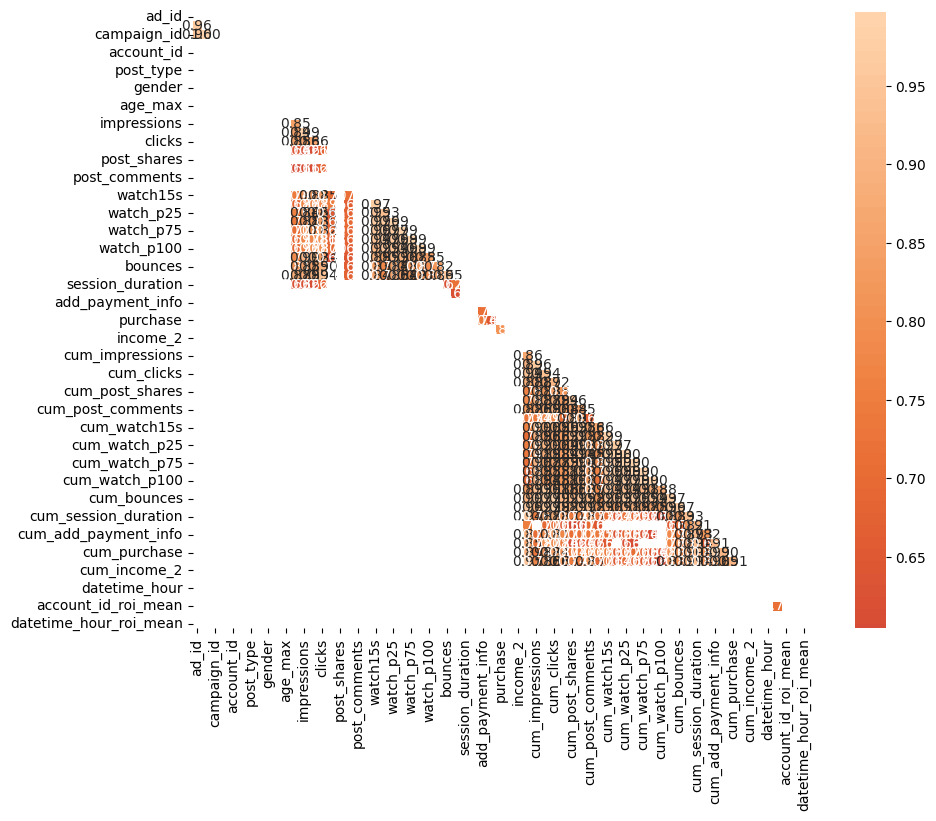

In [19]:
mask1 = np.triu(np.ones_like(matrix, dtype=bool))
mask2 = np.abs(matrix) <= 0.6
mask = mask1 | mask2

plt.figure(figsize=(12, 8))
sns.heatmap(matrix, mask = mask, center = 0, annot = True, fmt = '.2f', square = True)
plt.show()

# Model

### 1. lightgbm

In [ ]:
# lightgbm
model = LGBMRegressor()

model.fit(
    train_data.iloc[:].drop('roi', axis=1),
    train_data.iloc[:]['roi'], categorical_feature=['ad_id', 'ad_set_id', 'campaign_id', 'product_id', 'account_id', 'post_id_emb', 'post_type', 'countries']
)

df = pd.read_csv('提交示例.csv')
df['roi'] = model.predict(test_data.iloc[:].drop('uuid', axis=1))
df.to_csv('submit.csv', index=None)

### 2. Time Series

In [ ]:
# Time Series

### 3. Linear Regression

In [4]:
# pip install CausalML


In [10]:
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 656419 entries, 0 to 656418
Data columns (total 69 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   ad_id                   656419 non-null  int64  
 1   ad_set_id               656419 non-null  int64  
 2   campaign_id             656419 non-null  int64  
 3   product_id              656419 non-null  int32  
 4   account_id              656419 non-null  int64  
 5   post_id_emb             656419 non-null  int32  
 6   post_type               656419 non-null  int64  
 7   countries               656419 non-null  int32  
 8   gender                  656419 non-null  int64  
 9   age_min                 656419 non-null  int64  
 10  age_max                 656419 non-null  int64  
 11  spend                   656419 non-null  float64
 12  impressions             656419 non-null  int64  
 13  reach                   656419 non-null  int64  
 14  clicks              

In [14]:
X = train_data.iloc[:].drop('roi', axis=1)
Y = train_data.iloc[:]['roi']

In [15]:
print(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 656419 entries, 0 to 656418
Data columns (total 68 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   ad_id                   656419 non-null  int64  
 1   ad_set_id               656419 non-null  int64  
 2   campaign_id             656419 non-null  int64  
 3   product_id              656419 non-null  int32  
 4   account_id              656419 non-null  int64  
 5   post_id_emb             656419 non-null  int32  
 6   post_type               656419 non-null  int64  
 7   countries               656419 non-null  int32  
 8   gender                  656419 non-null  int64  
 9   age_min                 656419 non-null  int64  
 10  age_max                 656419 non-null  int64  
 11  spend                   656419 non-null  float64
 12  impressions             656419 non-null  int64  
 13  reach                   656419 non-null  int64  
 14  clicks              

In [16]:
print(Y.info())

<class 'pandas.core.series.Series'>
RangeIndex: 656419 entries, 0 to 656418
Series name: roi
Non-Null Count   Dtype  
--------------   -----  
656419 non-null  float64
dtypes: float64(1)
memory usage: 5.0 MB
None


In [17]:
regression_equation = linear_model.LinearRegression()
regression_equation.fit(X,Y)

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [9]:
# Linear Regression

model = LinearRegression()
model.fit(
    train_data.iloc[:].drop('roi', axis=1),
    train_data.iloc[:]['roi']
)




ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values